In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from hessians_calc import *
from demo_parity_calc import *

In [4]:
df = pd.read_csv('compas-scores-two-years.csv')

In [5]:
df = df[['event', 'is_violent_recid', 'is_recid', 'priors_count', 'juv_other_count','juv_misd_count', 'juv_fel_count', 'race', 'age_cat', 'sex','score_text']]

In [6]:
def preprocess_compas(df):
    df['age_cat'] = df['age_cat'].map({'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}).astype(int)    
    df['score_text'] = df['score_text'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)    
    df['race'] = df['race'].map({'Other': 0, 'African-American': 0, 'Hispanic': 0, 'Native American': 0, 'Asian': 0, 'Caucasian': 1}).astype(int)
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)    
    
    df.loc[(df['priors_count'] <= 5), 'priors_count'] = 0
    df.loc[(df['priors_count'] > 5) & (df['priors_count'] <= 15), 'priors_count'] = 1
    df.loc[(df['priors_count'] > 15), 'priors_count'] = 2
    
    df.loc[(df['juv_fel_count'] == 0), 'juv_fel_count'] = 0
    df.loc[(df['juv_fel_count'] == 1), 'juv_fel_count'] = 1
    df.loc[(df['juv_fel_count'] > 1), 'juv_fel_count'] = 2
    
    df.loc[(df['juv_misd_count'] == 0), 'juv_misd_count'] = 0
    df.loc[(df['juv_misd_count'] == 1), 'juv_misd_count'] = 1
    df.loc[(df['juv_misd_count'] > 1), 'juv_misd_count'] = 2
    
    df.loc[(df['juv_other_count'] == 0), 'juv_other_count'] = 0
    df.loc[(df['juv_other_count'] == 1), 'juv_other_count'] = 1
    df.loc[(df['juv_other_count'] > 1), 'juv_other_count'] = 2
    return df

In [7]:
df = preprocess_compas(df)

In [8]:
df.shape[0]

7214

In [9]:
y = df['is_recid']

In [10]:
df = df.drop(columns=['is_recid', 'is_violent_recid'])

In [40]:
df.size

11542

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [41]:
11542*0.8


9233.6

In [12]:
X_train.head()

,event,priors_count,juv_other_count,juv_misd_count,juv_fel_count,race,age_cat,sex,score_text
0,0,1,2,2,0,0,1,1,2
1,0,1,0,0,0,1,1,1,0
2,0,0,0,0,0,1,1,1,0
3,1,2,0,0,2,0,1,0,2
4,0,0,0,0,0,1,1,1,0


In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [37]:
X_train.size

51939

In [14]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    # sc = StandardScaler()
    # x_test_scalar_temp = sc.fit_transform(x_test_temp)
    # x_train_scalar_temp = sc.fit_transform(x_train_temp)
    # y_train_scalar_temp = sc.fit_transform(y_train_temp)
    # clfl = eval(clf_name)(input_size=x_train_temp.shape[-1])
    # clfl.fit(x_train_scalar_temp, y_train_scalar_temp)

    # y_pred_proba_temp = clfl.predict_proba(x_test_scalar_temp)
    X_test_sc = sc.transform(x_test_temp)
    
    clf = LogisticRegression(input_size=X_train.shape[-1])

    clf.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(X_test_sc)

    privileged_gp_indices = x_test_temp[x_test_temp['race'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['race'] == 0].index  # male: 1, female: 0

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  protected_positive_pred - privileged_positive_pred

In [15]:
dp_ori = demographic_parity(X_train, y_train, X_test)

In [16]:
print(dp_ori)

0.10664560881682311


In [17]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

result_plot = []
result = {}

for i in range(len(X_train)):
    x_train_new = np.append(x_train_a, [X_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, X_test)
    result[i] = res
    result_plot.append(res)

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [18]:
# sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [19]:
sorted_result = dict(sorted(result.items(), key=lambda item: -item[1]))

In [20]:
#Define the counts for which to calculate dp
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 500 data points: {0: 0.10664560881682311, 500: 0.04348843285280213}
Demographic Parity for first 1000 data points: {0: 0.10664560881682311, 500: 0.04348843285280213, 1000: 0.02546546663615029}
Demographic Parity for first 1500 data points: {0: 0.10664560881682311, 500: 0.04348843285280213, 1000: 0.02546546663615029, 1500: 0.013508498497862675}
Demographic Parity for first 2000 data points: {0: 0.10664560881682311, 500: 0.04348843285280213, 1000: 0.02546546663615029, 1500: 0.013508498497862675, 2000: 0.005323681212545339}
Demographic Parity for first 2500 data points: {0: 0.10664560881682311, 500: 0.04348843285280213, 1000: 0.02546546663615029, 1500: 0.013508498497862675, 2000: 0.005323681212545339, 2500: 0.0002320852044437327}
Demographic Parity for first 3000 data points: {0: 0.10664560881682311, 500: 0.04348843285280213, 1000: 0.02546546663615029, 1500: 0.013508498497862675, 2000: 0.005323681212545339, 2500: 0.0002320852044437327, 3000: 0.0026679766181370

In [21]:
X_train.size
X_test.size

12987

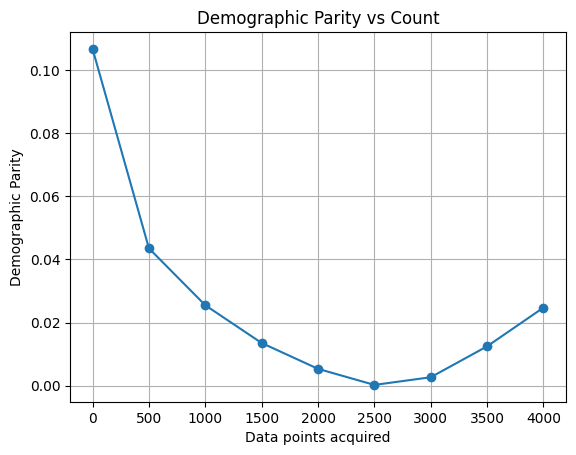

In [22]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [23]:
#Define the counts for which to calculate dp
counts_to_check = [2400, 2450, 2500, 2550, 2600]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 2400 data points: {2400: 0.0010146116717588693}
Demographic Parity for first 2450 data points: {2400: 0.0010146116717588693, 2450: 0.0006172730518475555}
Demographic Parity for first 2500 data points: {2400: 0.0010146116717588693, 2450: 0.0006172730518475555, 2500: 0.0002320852044437327}
Demographic Parity for first 2550 data points: {2400: 0.0010146116717588693, 2450: 0.0006172730518475555, 2500: 0.0002320852044437327, 2550: -0.00014164712298608828}
Demographic Parity for first 2600 data points: {2400: 0.0010146116717588693, 2450: 0.0006172730518475555, 2500: 0.0002320852044437327, 2550: -0.00014164712298608828, 2600: -0.000551364123783149}


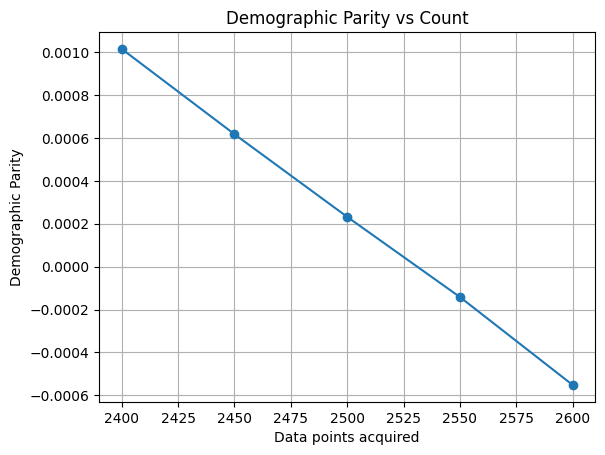

In [24]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [25]:
#Define the counts for which to calculate dp
counts_to_check = [2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 2500 data points: {2500: 0.0002320852044437327}
Demographic Parity for first 2505 data points: {2500: 0.0002320852044437327, 2505: 0.0001942121505588701}
Demographic Parity for first 2510 data points: {2500: 0.0002320852044437327, 2505: 0.0001942121505588701, 2510: 0.00015646568657284865}
Demographic Parity for first 2515 data points: {2500: 0.0002320852044437327, 2505: 0.0001942121505588701, 2510: 0.00015646568657284865, 2515: 0.00011880620128013053}
Demographic Parity for first 2520 data points: {2500: 0.0002320852044437327, 2505: 0.0001942121505588701, 2510: 0.00015646568657284865, 2515: 0.00011880620128013053, 2520: 8.127387141981801e-05}
Demographic Parity for first 2525 data points: {2500: 0.0002320852044437327, 2505: 0.0001942121505588701, 2510: 0.00015646568657284865, 2515: 0.00011880620128013053, 2520: 8.127387141981801e-05, 2525: 4.385230466652512e-05}
Demographic Parity for first 2530 data points: {2500: 0.0002320852044437327, 2505: 0.00019421215

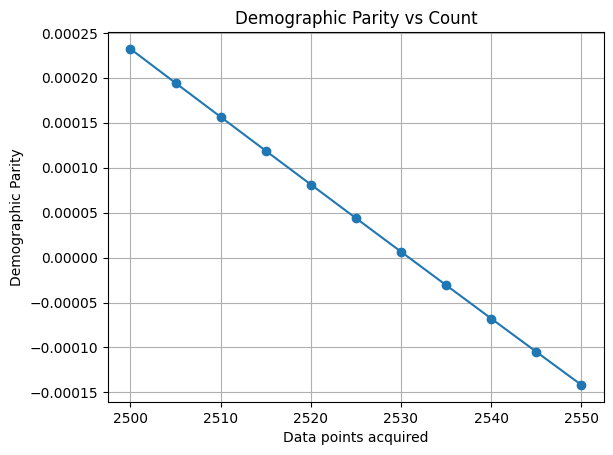

In [26]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [27]:
# number of data points to be acquired for minimizing the parity would be around 2530

In [28]:
clf = eval('LogisticRegression')(input_size=X_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_test_scaler = sc.fit_transform(X_test)

In [30]:
del_F_del_theta = del_spd_del_theta_com(clf, X_test, x_test_scaler, y_test)

In [31]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 5771/5771 [00:16<00:00, 340.43it/s]


In [32]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(5771, 10)


In [33]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 

In [34]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta)) 

In [44]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf / 5771
print(inf.shape)

(5771,)


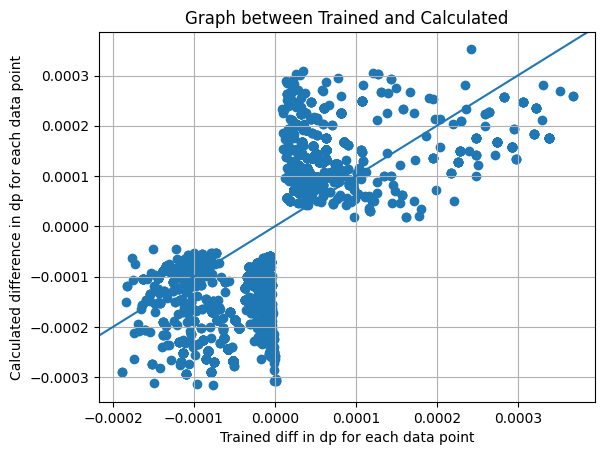

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result_plot, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated difference in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()


In [46]:
inf_list = {index: value for index, value in enumerate(inf)}

In [58]:
# INFLUENCE BASED SORTED DP FOR EACH DATA POINT
sorted_result_inf = {k: v for k, v in sorted(inf_list.items(), key=lambda item: -item[1])}

In [61]:
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

dp_inf[0] = dp_ori

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 500 data points: {0: 0.10664560881682311, 500: 0.05834147121746314}
Demographic Parity for first 1000 data points: {0: 0.10664560881682311, 500: 0.05834147121746314, 1000: 0.036409987408318634}
Demographic Parity for first 1500 data points: {0: 0.10664560881682311, 500: 0.05834147121746314, 1000: 0.036409987408318634, 1500: 0.023351782404735066}
Demographic Parity for first 2000 data points: {0: 0.10664560881682311, 500: 0.05834147121746314, 1000: 0.036409987408318634, 1500: 0.023351782404735066, 2000: 0.011063002438075231}
Demographic Parity for first 2500 data points: {0: 0.10664560881682311, 500: 0.05834147121746314, 1000: 0.036409987408318634, 1500: 0.023351782404735066, 2000: 0.011063002438075231, 2500: 0.0039686454837507545}
Demographic Parity for first 3000 data points: {0: 0.10664560881682311, 500: 0.05834147121746314, 1000: 0.036409987408318634, 1500: 0.023351782404735066, 2000: 0.011063002438075231, 2500: 0.0039686454837507545, 3000: 0.01127851531

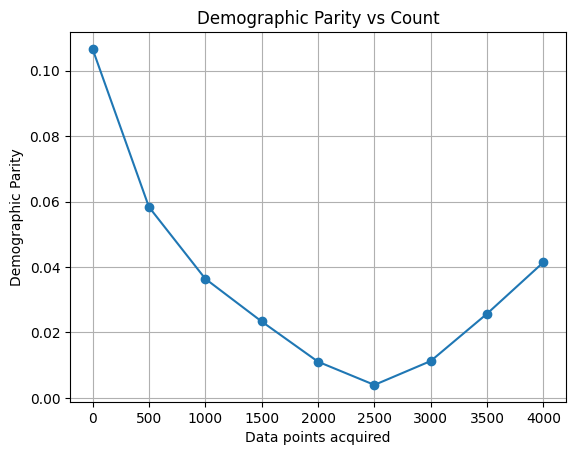

In [62]:
import matplotlib.pyplot as plt

counts = list(dp_inf.keys())
dp_values_inf = list(dp_inf.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values_inf, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [ ]:
#2550 data points 